### Ryan's Models

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold, train_test_split
from sklearn.externals import joblib
import sklearn.neural_network
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import cPickle as pickle

%matplotlib inline

In [2]:
%%time 
"""
Read in train/validate and test as Pandas DataFrames
"""
df_train = pd.read_csv("train")
df_test = pd.read_csv("test")
df_features = pd.DataFrame.from_csv("array_touse.csv", index_col=None, header=None)

CPU times: user 3min 14s, sys: 25.8 s, total: 3min 40s
Wall time: 3min 47s


In [3]:
df_train.shape, df_test.shape, df_features.shape

((1000000, 258), (824230, 258), (1824230, 264))

In [4]:
df_train.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256,gap
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.19
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1.60
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.49
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.36
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.98


In [5]:
df_test.head()

,Id,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,1,c1sc(-c2cnc3c(c2)c2nsnc2c2cc4cccnc4cc32)c2cc[n...,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,[nH]1cccc1-c1cc2c3nsnc3c3c4sccc4[nH]c3c2s1,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
2,3,[nH]1c2cc(-c3ccc[se]3)c3nsnc3c2c2c3cscc3c3ccc4...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,[nH]1c(cc2cnc3c(c12)c1=C[SiH2]C=c1c1ccc2=CCC=c...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,c1sc(-c2sc(-c3sc(-c4scc5[se]ccc45)c4ccoc34)c3c...,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


## Training-validation split
Having done feature engineering, we split the training data into training (60%), validation (20%), and test (20%) sets.
http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio

In [3]:
Y = df_train.gap

In [4]:
df_feat_train     = df_features.ix[:999999, ]
df_feat_supertest = df_features.ix[1000000:, ].values

# mask for our testing data
train_mask = np.genfromtxt('val_train_split.csv', delimiter=",")
train_mask = [bool(x) for x in train_mask]
test_mask  = [not x for x in train_mask]

df_feat_test  = df_feat_train[test_mask]
df_feat_train = df_feat_train[train_mask]

Y_train_all = Y[train_mask].values
Y_test  = Y[test_mask].values

df_feat_train.shape, df_feat_test.shape, df_feat_supertest.shape, Y_train_all.shape

((800787, 264), (199213, 264), (824230, 264), (800787,))

Here are our sample dataframes that we use for quick model tuning

In [5]:
X_train_samp, X_validate_samp, Y_train_samp, Y_validate_samp = train_test_split(df_feat_train,
                                                                                Y_train_all,
                                                                                train_size=.15,
                                                                                test_size=.05)

In [6]:
X_train_samp.shape, X_validate_samp.shape, Y_train_samp.shape, Y_validate_samp.shape

((120118, 264), (40040, 264), (120118,), (40040,))

Here are the full train/validate dataframes which we will use to get our final models

In [7]:
X_train, X_validate, Y_train, Y_validate = train_test_split(df_feat_train,
                                                            Y_train_all,
                                                            train_size=.75,
                                                            test_size=.25)

In [8]:
X_train.shape, X_validate.shape, Y_train.shape, Y_validate.shape

((600590, 264), (200197, 264), (600590,), (200197,))

### Random Forest Regression

In [11]:
def rf_regress(X_train, Y_train, X_validate, Y_validate,
               n_estimators=10, max_features="auto", bootstrap="true"):
    RF = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, bootstrap=bootstrap)
    RF.fit(X_train, Y_train)
    RF_val_pred   = RF.predict(X_validate)
    RF_train_pred = RF.predict(X_train)
    RF_MSE = mean_squared_error(Y_validate,RF_val_pred)
    RF_MSE_train = mean_squared_error(Y_train, RF_train_pred)
    ##RF_pred = RF.predict(X_test)
#     try:
#         RMSE_dict[name].append((RF_MSE, n_estimators, max_features, bootstrap))
#     except:
#         RMSE_dict[name] = [(RF_MSE, n_estimators, max_features, bootstrap)]
    
#     RMSE_dict[name] = (RF_MSE, n_estimators, max_features, bootstrap)
    return RF_MSE_train, RF_MSE, RF
    

Time to try this on our big dataset and make an actual prediction. This model is relativly short to run, so I decide not to pickle it. Instead I just save the prediction.

In [62]:
%%time
a, b, RF_model = rf_regress(X_train, Y_train, X_validate, Y_validate, n_estimators=20)
joblib.dump(RF_model, "model_pickles/RF_model.pkl")
print("RMSE Train", a)
print("RMSE Validate", b)

RMSE Train 0.0196712111518
RMSE Validate 0.0271991958541
CPU times: user 1min 33s, sys: 2.51 s, total: 1min 36s
Wall time: 1min 38s


Reload the model from pickle and predict large test dataset

In [23]:
RF_model = joblib.load("model_pickles/RF_model.pkl")

In [65]:
def write_to_file(filename, predictions):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(predictions):
            f.write(str(i+1) + "," + str(p) + "\n")

In [76]:
RF_super_predict = RF_model.predict(df_feat_supertest)

In [77]:
write_to_file("rf_prediction.csv", RF_super_predict)

### AdaBoost Regression

In [39]:
def ab_regress(X_train, Y_train, X_validate, Y_validate,
               n_estimators=50, loss="linear"):
    AB = AdaBoostRegressor(n_estimators=n_estimators, loss=loss)
    AB.fit(X_train, Y_train)
    AB_val_pred   = AB.predict(X_validate)
    AB_train_pred = AB.predict(X_train)
    AB_MSE       = mean_squared_error(Y_validate, AB_val_pred)
    AB_MSE_train = mean_squared_error(Y_train, AB_train_pred)
    return AB_MSE_train, AB_MSE, AB

In [60]:
%%time
AB_MSE_train, AB_MSE_validate, AB_model = rf_regress(X_train, Y_train,
                                                     X_validate, Y_validate, n_estimators=60)
joblib.dump(AB_model, "model_pickles/AB_model.pkl")
print("RMSE Train", AB_MSE_train)
print("RMSE Validate", AB_MSE_validate)

RMSE Train 0.0195409777944
RMSE Validate 0.026986349333
CPU times: user 4min 31s, sys: 5.71 s, total: 4min 37s
Wall time: 4min 41s


Reload the model from pickle and predict on large test set

In [22]:
AB_model = joblib.load("model_pickles/AB_model.pkl")

In [79]:
AB_super_predict = RF_model.predict(df_feat_supertest)
write_to_file("ab_prediction.csv", AB_super_predict)

#### AdaBoost tuning

In [56]:
%%time
n_estimators = [1, 3, 5, 10, 20, 30, 50, 70, 100]
AB_train_results    = [None] * len(n_estimators)
AB_validate_results = [None] * len(n_estimators)

for i, n in enumerate(n_estimators):
    print(n)
    AB_train_results[i], AB_validate_results[i], _ = ab_regress(X_train_samp, Y_train_samp,
                                                                X_validate_samp, Y_validate_samp, n_estimators=n)

1
3
5
10
20
30
50
70
100
CPU times: user 5min 42s, sys: 9.33 s, total: 5min 51s
Wall time: 5min 55s


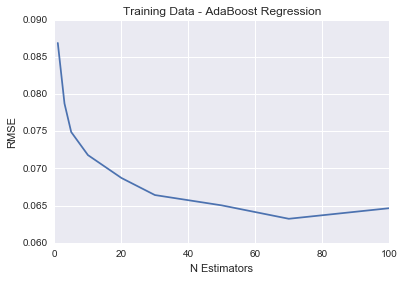

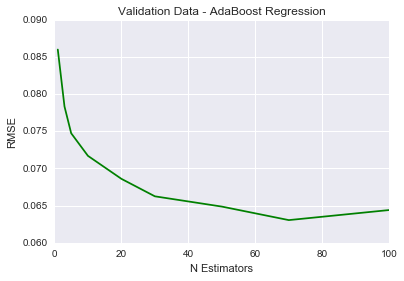

In [57]:
plt.plot(n_estimators, AB_train_results)
plt.xlabel("N Estimators")
plt.ylabel("RMSE")
plt.title("Training Data - AdaBoost Regression")
plt.show()
plt.plot(n_estimators, AB_validate_results, c='g')
plt.xlabel("N Estimators")
plt.ylabel("RMSE")
plt.title("Validation Data - AdaBoost Regression")

### Graphs to decide what number of estimators to choose

In [51]:
%%time
n_estimators = range(1, 41, 2)
RF_train_results    = [None] * len(n_estimators)
RF_validate_results = [None] * len(n_estimators)

for i, n in enumerate(n_estimators):
    RF_train_results[i], RF_validate_results[i], _ = rf_regress(X_train_samp, Y_train_samp,
                                                                X_validate_samp, Y_validate_samp, n_estimators=n)
    

CPU times: user 5min 9s, sys: 6.6 s, total: 5min 16s
Wall time: 5min 21s


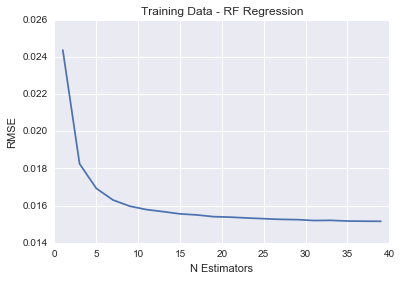

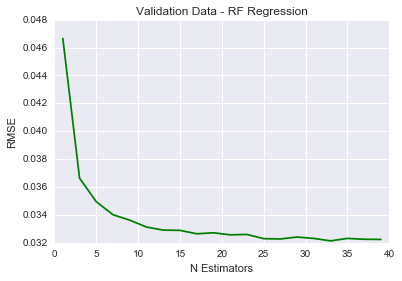

In [61]:
n_estimators = range(1, 41, 2)

plt.plot(n_estimators, RF_train_results)
plt.xlabel("N Estimators")
plt.ylabel("RMSE")
plt.title("Training Data - RF Regression")
plt.show()
plt.plot(n_estimators, RF_validate_results, c='g')
plt.xlabel("N Estimators")
plt.ylabel("RMSE")
plt.title("Validation Data - RF Regression")

# Madhu's Models

### Linear Regression

In [12]:
%%time
LR = LinearRegression()
LR.fit(X_train, Y_train)
rmse_linear = mean_squared_error(Y_validate, LR.predict(X_validate))
print(rmse_linear)

0.0476006935856
CPU times: user 17.4 s, sys: 1.99 s, total: 19.4 s
Wall time: 12.2 s


### Ridge Regression

Optimal alpha: 10.0
New optimal alpha: 10.0
0.0476008779386
CPU times: user 1min 9s, sys: 22.6 s, total: 1min 31s
Wall time: 1min 5s


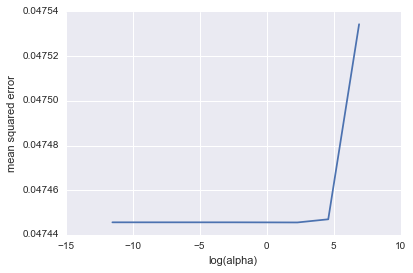

In [13]:
%%time
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
RR = RidgeCV(alphas=alphas, store_cv_values=True)
RR.fit(X_train, Y_train)
best_alpha = RR.alpha_
print('Optimal alpha:', best_alpha)
plt.plot(np.log(alphas), RR.cv_values_.mean(axis=0))
plt.xlabel('log(alpha)')
plt.ylabel('mean squared error')

RR = RidgeCV(alphas = [best_alpha*0.3, best_alpha, best_alpha*3])
RR.fit(X_train, Y_train)
best_alpha = RR.alpha_
print('New optimal alpha:', best_alpha)

rmse_ridge = mean_squared_error(Y_validate, RR.predict(X_validate))
print(rmse_ridge)

### Lasso Regression

Optimal alpha: 1e-05
New optimal alpha: 3e-06
0.047678525754
CPU times: user 5min 50s, sys: 14.1 s, total: 6min 4s
Wall time: 3min 29s


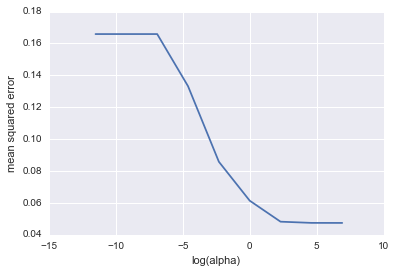

In [15]:
%%time
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
LassoModel = LassoCV(alphas = alphas)
LassoModel.fit(X_train, Y_train)
best_alpha = LassoModel.alpha_
print('Optimal alpha:', best_alpha)
plt.plot(np.log(alphas), LassoModel.mse_path_.mean(axis=-1))
plt.xlabel('log(alpha)')
plt.ylabel('mean squared error')

LassoModel = LassoCV(alphas = [best_alpha*0.3, best_alpha, best_alpha*3])
LassoModel.fit(X_train, Y_train)
best_alpha = LassoModel.alpha_
print('New optimal alpha:', best_alpha)

rmse_lasso = mean_squared_error(Y_validate, LassoModel.predict(X_validate))
print(rmse_lasso)

### Elastic Net

In [16]:
%%time
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
EN = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas)
EN.fit(X_train, Y_train)
print('Optimal alpha:', EN.alpha_)
print('Optimal L1 ratio:', EN.l1_ratio_)
print(mean_squared_error(Y_validate, EN.predict(X_validate)))

Optimal alpha: 0.0001
Optimal L1 ratio: 0.1
0.0476848366022
CPU times: user 4min 20s, sys: 22.1 s, total: 4min 42s
Wall time: 3min 3s


Pickling these models

In [19]:
pickle.dump(EN, open("model_pickles/EN_model.p", "wb"))
pickle.dump(LassoModel, open("model_pickles/LassoModel_model.p", "wb"))
pickle.dump(RR, open("model_pickles/RR_model.p", "wb"))

In [20]:
EN = pickle.load(open("model_pickles/EN_model.p", "rb"))
LassoModel = pickle.load(open("model_pickles/LassoModel_model.p", "rb"))
RR = pickle.load(open("model_pickles/RR_model.p", "rb"))

## Testing models

In [24]:
RF_test_pred = RF_model.predict(df_feat_test)
AB_test_pred = AB_model.predict(df_feat_test)
EN_test_pred = EN.predict(df_feat_test)
RR_test_pred = RR.predict(df_feat_test)
LassoModel_test_pred = LassoModel.predict(df_feat_test)

RF_RMSE = mean_squared_error(Y_test, RF_test_pred)**0.5
AB_RMSE = mean_squared_error(Y_test, AB_test_pred)**0.5
EN_RMSE = mean_squared_error(Y_test, EN_test_pred)**0.5
RR_RMSE = mean_squared_error(Y_test, RR_test_pred)**0.5
LassoModel_RMSE = mean_squared_error(Y_test, LassoModel_test_pred)**0.5



print("RF:", RF_RMSE)
print("AB:", AB_RMSE)
print("EN:", EN_RMSE)
print("RR:", RR_RMSE)
print("Lasso:", LassoModel_RMSE)

RF: 0.164176741539
AB: 0.163681817034
EN: 0.217767450644
RR: 0.217609329603
Lasso: 0.217755734399


Looks like the AdaBoost predictor was a little bit better!

### Testing out k-fold validation

In [19]:
kf = KFold(50, 5, shuffle=True)

for train, test in kf:
    print(train, test)

[ 0  1  2  4  5  6  7 10 11 12 13 14 15 16 17 18 20 21 23 24 25 26 27 28 30
 31 32 34 35 36 37 38 39 40 41 42 43 44 45 49] [ 3  8  9 19 22 29 33 46 47 48]
[ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 18 19 20 21 22 23 25 27 29 30
 31 32 33 34 35 36 37 38 40 41 43 45 46 47 48] [ 0 10 17 24 26 28 39 42 44 49]
[ 0  1  3  5  8  9 10 11 14 15 16 17 18 19 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 38 39 40 41 42 43 44 46 47 48 49] [ 2  4  6  7 12 13 20 36 37 45]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 17 18 19 20 22 24 26 27 28 29
 32 33 34 35 36 37 38 39 42 44 45 46 47 48 49] [11 16 21 23 25 30 31 40 41 43]
[ 0  2  3  4  6  7  8  9 10 11 12 13 16 17 19 20 21 22 23 24 25 26 28 29 30
 31 33 36 37 39 40 41 42 43 44 45 46 47 48 49] [ 1  5 14 15 18 27 32 34 35 38]


### Testing out PyBrain

In [41]:
from pybrain.datasets.supervised import SupervisedDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer

In [42]:
X_train.shape, np.array(Y_train).shape

((59933, 256), (59933,))

In [43]:
ds = SupervisedDataSet(X_train.shape[1], 1)
Y_train_neural = np.array(Y_train).reshape(-1, 1)
ds.setField('input', X_train)
ds.setField('target', Y_train_neural)

In [46]:
%%time
hidden_size = 100   # arbitrarily chosen

net = buildNetwork( X_train.shape[1], hidden_size, 1, bias = True )
trainer = BackpropTrainer( net, ds )

trainer.trainUntilConvergence( verbose = True, validationProportion = 0.15, maxEpochs = 100, continueEpochs = 10 )

KeyboardInterrupt: 

### sklearn Neural Network

In [28]:
from sknn.mlp import Regressor, Layer

Y_train_nn = np.array(Y_train)

nn = Regressor(
    layers=[
        Layer("Rectifier", units=100),
        Layer("Linear")],
    learning_rate=0.02,
    n_iter=10)
nn.fit(X_train, Y_train_nn)

INFO (theano.gof.compilelock): Refreshing lock /Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/lock_dir/lock


ImportError: ('The following error happened while compiling the node', Dot22(X, W), '\n', 'dlopen(/Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/tmp5nTyH1/eb163660e6e45b373cd7909e14efd44a.so, 2): Library not loaded: libmkl_intel_lp64.dylib\n  Referenced from: /Users/ryankerr/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-2.7.11-64/tmp5nTyH1/eb163660e6e45b373cd7909e14efd44a.so\n  Reason: image not found', '[Dot22(X, W)]')

In [30]:
print(np.distutils.__config__.show())

lapack_opt_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/include']
blas_opt_info:
    libraries = ['mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/include']
openblas_lapack_info:
  NOT AVAILABLE
lapack_mkl_info:
    libraries = ['mkl_lapack95_lp64', 'mkl_intel_lp64', 'mkl_intel_thread', 'mkl_core', 'iomp5', 'pthread']
    library_dirs = ['/Users/ryankerr/anaconda/envs/dev-sklearn/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ryankerr/anaconda/envs/dev-skle